# **Assignment 2 - Kaggle ML & DS Survey Challenge**

**Course**: MIE1624 - Introduction to Data Science and Analytics

**Professor**: Dr. Oleksandr Romanko, PhD.

**Due Date**:  11:59pm, 7 Mar 2021

**Student**:  Sugumar Prabhakaran (**id#**: 994126815)

### **Question 1 - Data Cleaning [2pts]**

While the data is made ready for analysis, several values are missing, and some features are
categorical. Note that some values that appear “null” indicate that a survey respondent did not select that given option from a multiple-choice list. For example: *“Which of the following hosted
notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - Binder
/ JupyterHub”*.

* For the data cleaning step, handle missing values however you see fit and justify your approach. Provide some insight on why you think the values are missing and how your approach might impact the overall analysis. Suggestions include filling the missing values with a certain value (e.g. mode for categorical data) and completely removing the features with missing values. 

* Secondly, convert categorical data into numerical data by encoding and explain why you used this particular encoding method.

These tasks can be done interchangeably, e.g., encoding can be done first.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import learning_curve

pd.set_option('max_columns', 10)

df = pd.read_csv('clean_kaggle_data_2020.csv', low_memory=False)

# drop survey completion time column since irrelevant to salary analysis
df.drop(columns=['Time from Start to Finish (seconds)'], inplace=True)

# rename columns Q1 to Q9 and Target Variable so they can be sorted
new_name = [x[:1]+'0'+x[1:] for x in list(df.columns[:32])]
col_dict = dict(zip(list(df.columns[:32]),new_name))
df.rename(columns=col_dict, inplace=True)
df.rename(columns={'Q24_Encoded':'Target_Encoded'}, inplace=True)
df = df.reindex(sorted(df.columns),axis=1)

print("df shape: ", df.shape, '\n')

df.head()

df shape:  (10730, 356) 



,Q01,Q02,Q03,Q04,Q05,...,Q39_Part_6,Q39_Part_7,Q39_Part_8,Q39_Part_9,Target_Encoded
0,What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,NaN
1,30-34,Man,United States of America,Master’s degree,Data Engineer,...,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,10.0
2,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,...,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,NaN,NaN,1.0
3,30-34,Man,United States of America,Master’s degree,Data Scientist,...,NaN,NaN,NaN,NaN,11.0
4,35-39,Man,Germany,Doctoral degree,Data Scientist,...,NaN,NaN,NaN,"Journal Publications (peer-reviewed journals, ...",7.0


In [2]:
#drop columns Q8 since its not relevant to salary
#drop column Q24 since data is contained in Q24_buckets
df.drop(columns=['Q08','Q24'], inplace=True)
#rename Q24_buckets without buckets
df.rename(columns={'Q24_buckets':'Q24'}, inplace=True)
print("df shape: ", df.shape, '\n')

df shape:  (10730, 354) 



In [3]:
#separate single columns and multi-cols using their titles
#ie. single_cols doesn't have titles that contain "Part" or "OTHER"
single_cols = [x for x in list(df.columns) \
                 if ("Part" not in x and "OTHER" not in x)]

#store questions in dictionaries so we can drop row
single_col_Qs = {x:df[x][:1].values[0] for x in single_cols}
single_col_Qs

{'Q01': 'What is your age (# years)?',
 'Q02': 'What is your gender? - Selected Choice',
 'Q03': 'In which country do you currently reside?',
 'Q04': 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?',
 'Q05': 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice',
 'Q06': 'For how many years have you been writing code and/or programming?',
 'Q11': 'What type of computing platform do you use most often for your data science projects? - Selected Choice',
 'Q13': 'Approximately how many times have you used a TPU (tensor processing unit)?',
 'Q15': 'For how many years have you used machine learning methods?',
 'Q20': 'What is the size of the company where you are employed?',
 'Q21': 'Approximately how many individuals are responsible for data science workloads at your place of business?',
 'Q22': 'Does your current employer incorporate machine learning methods into their busin

In [86]:
multi_cols = [x for x in list(df.columns) if x not in single_cols]
multi_col_Qs = {x:df[x][:1].values[0] for x in multi_cols}

#multi_col_Qs

In [5]:
# We can get rid of first row with questions now since we have info in dicts
df.drop(index = 0, inplace=True)
print("new df shape: ", df.shape, '\n')

new df shape:  (10729, 354) 



#### **1.A. Single-Column Ordinal Categorical Data:**  The following columns contain ordinal categorical data so they can be encoded using ordered integers:

 * Q01  - Age
 * Q04  - Education level
 * Q06  - Years of Coding Exp.
 * Q13 - Times used a TPU
 * Q15 - Years using ML
 * Q20 - Size of Company
 * Q21 - No. of Data Scientists in Company
 * Q22 - Level of Incorp. ML at Company
 * Q25 - Money spent by Company on ML
 * Target_Encoded - Q24 Yearly Salary Bracket (**already encoded**)


In [6]:
#create new df for encoded columns.  So far, only target is encoded
df2 = pd.DataFrame(df['Target_Encoded'])

#split single cols into ones for one_hot encoding and ones for ordinal encoding
one_hot_encode_cols = ['Q02','Q03','Q05','Q11','Q30','Q32','Q38']
ordinal_encode_cols = [x for x in single_cols if x not in one_hot_encode_cols
                         and x != 'Q24' and x != 'Target_Encoded']
ordinal_encode_cols

['Q01', 'Q04', 'Q06', 'Q13', 'Q15', 'Q20', 'Q21', 'Q22', 'Q25']

In [7]:
df[ordinal_encode_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10729 entries, 1 to 10729
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q01     10729 non-null  object
 1   Q04     10729 non-null  object
 2   Q06     10729 non-null  object
 3   Q13     10168 non-null  object
 4   Q15     10168 non-null  object
 5   Q20     10729 non-null  object
 6   Q21     10729 non-null  object
 7   Q22     10729 non-null  object
 8   Q25     10570 non-null  object
dtypes: object(9)
memory usage: 838.2+ KB


In [8]:
# rename some values for Q13, Q15 and Q25 so that graph is shorter
df['Q13'] = df['Q13'].map({'More than 25 times':'25+ times'}).fillna(df['Q13'])
df['Q15'] = df['Q15'].map({'I do not use machine learning methods': '0 years',
                            '20 or more years': '20+ years'}).fillna(df['Q15'])
df['Q25'] = df['Q25'].map({ '$100,000 or more ($USD)':'$100,000+ ($USD)'}).fillna(df['Q25'])
df['Q13'].value_counts()

Never         7039
2-5 times     1422
Once          1202
6-25 times     305
25+ times      200
Name: Q13, dtype: int64

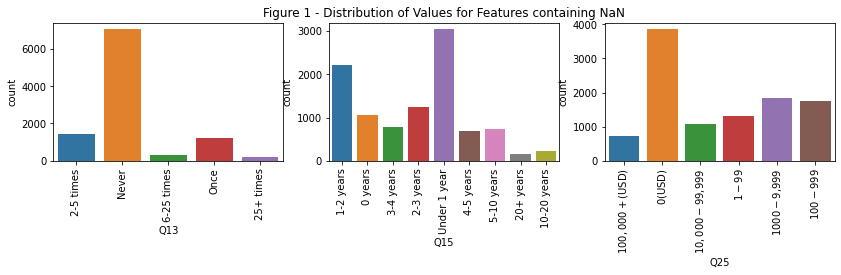

In [9]:
#We plot the distribution for each column with missing data: Q13, Q15, Q25:
fig, axes = plt.subplots(1,3, figsize=(14,4))

sns.countplot(x='Q13', data=df, ax =axes[0])
sns.countplot(x='Q15', data=df, ax =axes[1])
sns.countplot(x='Q25', data=df, ax =axes[2])

axes[1].set_title('Figure 1 - Distribution of Values for Features containing NaN', 
                  loc='center')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
fig.subplots_adjust(bottom=0.4)
#plt.tight_layout
#plt.savefig('figure1.png', dpi=550)
plt.show()

In [10]:
#for Q13, vast majority have never used TPU so we fill na with this:
df.at[df['Q13'].isnull(), 'Q13'] = 'Never'
#for Q15, median would be '1-2 years' since there are 10000 data points
df.at[df['Q15'].isnull(), 'Q15'] = '1-2 years'
#for Q25, vast majority are 0(USD)
df.at[df['Q25'].isnull(), 'Q25'] = '$0 ($USD)'

#verify that those values are no longer null
df[df['Q13'].isnull() | df['Q15'].isnull() | df['Q25'].isnull()]

,Q01,Q02,Q03,Q04,Q05,...,Q39_Part_6,Q39_Part_7,Q39_Part_8,Q39_Part_9,Target_Encoded


In [11]:
df['Q01'].value_counts()

25-29    2350
30-34    1979
35-39    1467
22-24    1424
40-44    1042
45-49     771
50-54     536
18-21     498
60-69     309
55-59     301
70+        52
Name: Q01, dtype: int64

In [12]:
df2['Q01'] = df['Q01'].map({'18-21':0, '22-24':1, '25-29':2, '30-34':3, 
                             '35-39':4, '40-44':5, '45-49':6, '50-54':7,
                             '55-59':8, '60-69':9, '70+':10}).fillna(df['Q01'])
df2['Q01'].value_counts()

2     2350
3     1979
4     1467
1     1424
5     1042
6      771
7      536
0      498
9      309
8      301
10      52
Name: Q01, dtype: int64

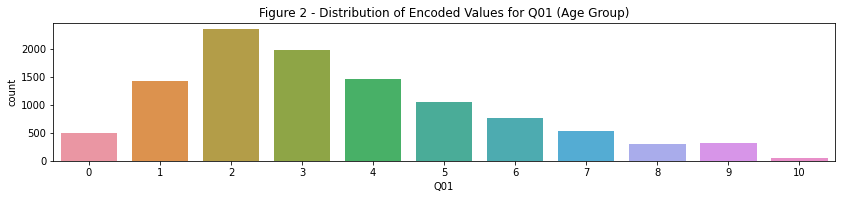

In [13]:
#We plot the distribution for each column with missing data: Q13, Q15, Q25:
fig, axes = plt.subplots(figsize=(14,4))

sns.countplot(x='Q01', data=df2)

plt.title('Figure 2 - Distribution of Encoded Values for Q01 (Age Group)', loc='center')
fig.subplots_adjust(bottom=0.4)
#plt.tight_layout
#plt.savefig('figure2.png', dpi=550)
plt.show()

In [14]:
df['Q04'].value_counts()

Master’s degree                                                      4879
Bachelor’s degree                                                    3013
Doctoral degree                                                      1718
Professional degree                                                   470
Some college/university study without earning a bachelor’s degree     385
I prefer not to answer                                                158
No formal education past high school                                  106
Name: Q04, dtype: int64

In [15]:
#we combine prefer not to answer with no formal education for simplicity. Small
#number of values
df2['Q04'] = df['Q04'].map({'Some college/university study without earning a bachelor’s degree': 1,
                         'Bachelor’s degree': 2,
                         'Professional degree': 3,
                         'Master’s degree': 4,
                         'Doctoral degree': 5}).fillna(0)

df2['Q04'].value_counts()

4.0    4879
2.0    3013
5.0    1718
3.0     470
1.0     385
0.0     264
Name: Q04, dtype: int64

In [16]:
df['Q06'].value_counts()

3-5 years                    2444
1-2 years                    1908
5-10 years                   1901
10-20 years                  1488
< 1 years                    1281
20+ years                    1146
I have never written code     561
Name: Q06, dtype: int64

In [17]:
df2['Q06'] = df['Q06'].map({'< 1 years': 1, '1-2 years': 2, 
                                    '3-5 years': 3, '5-10 years': 4, 
                                    '10-20 years':5, '20+ years': 6}).fillna(0)
df2['Q06'].value_counts()

3.0    2444
2.0    1908
4.0    1901
5.0    1488
1.0    1281
6.0    1146
0.0     561
Name: Q06, dtype: int64

In [18]:
df['Q13'].value_counts()

Never         7600
2-5 times     1422
Once          1202
6-25 times     305
25+ times      200
Name: Q13, dtype: int64

In [19]:
df2['Q13'] = df['Q13'].map({'Never': 0, 'Once': 1, 
                                    '2-5 times': 2, '6-25 times': 3, 
                                    '25+ times':4}).fillna(df['Q13'])
df2['Q13'].value_counts()

0    7600
2    1422
1    1202
3     305
4     200
Name: Q13, dtype: int64

In [20]:
df['Q15'].value_counts()

Under 1 year    3038
1-2 years       2784
2-3 years       1248
0 years         1055
3-4 years        772
5-10 years       746
4-5 years        693
10-20 years      229
20+ years        164
Name: Q15, dtype: int64

In [21]:
df2['Q15'] = df['Q15'].map({'0 years': 0, 'Under 1 year': 1, '1-2 years': 2, 
                            '2-3 years': 3, '3-4 years': 4, '4-5 years':5, 
                            '5-10 years': 6,'10-20 years': 7, '20+ years': 8}
                           ).fillna(df['Q15'])
df2['Q15'].value_counts()

1    3038
2    2784
3    1248
0    1055
4     772
6     746
5     693
7     229
8     164
Name: Q15, dtype: int64

In [22]:
df['Q20'].value_counts()

0-49 employees              3876
10,000 or more employees    2117
1000-9,999 employees        1843
50-249 employees            1598
250-999 employees           1295
Name: Q20, dtype: int64

In [23]:
df2['Q20'] = df['Q20'].map({'0-49 employees': 1, '50-249 employees': 5, 
                                        '250-999 employees': 20, 
                                        '1000-9,999 employees': 200, 
                                        '10,000 or more employees': 250}).fillna(df['Q20'])
df2['Q20'].value_counts()

1      3876
250    2117
200    1843
5      1598
20     1295
Name: Q20, dtype: int64

In [24]:
df['Q21'].value_counts()

1-2      2526
20+      2151
0        2121
3-4      1708
5-9      1263
10-14     665
15-19     295
Name: Q21, dtype: int64

In [25]:
df2['Q21'] = df['Q21'].map({'0': 0, '1-2': 1, '3-4': 3, '5-9': 7, 
                                        '10-14': 12, '15-19': 17,
                                         '20+': 25}).fillna(df['Q21'])
df2['Q21'].value_counts()

1     2526
25    2151
0     2121
3     1708
7     1263
12     665
17     295
Name: Q21, dtype: int64

In [26]:
df['Q22'].value_counts()

We are exploring ML methods (and may one day put a model into production)                    2285
No (we do not use ML methods)                                                                2136
We have well established ML methods (i.e., models in production for more than 2 years)       1872
We recently started using ML methods (i.e., models in production for less than 2 years)      1749
I do not know                                                                                1469
We use ML methods for generating insights (but do not put working models into production)    1218
Name: Q22, dtype: int64

In [27]:
#We set "I do not know" to 1 since distribution is rougly even and we dont
#want to skew results too much by setting = 0 or 2
df2['Q22']= df['Q22'].map({'No (we do not use ML methods)': 0,
               'We are exploring ML methods (and may one day put a model into production)': 1,
               'We use ML methods for generating insights (but do not put working models into production)': 2,
               'We recently started using ML methods (i.e., models in production for less than 2 years)': 3,
               'We have well established ML methods (i.e., models in production for more than 2 years)': 4,
               'I do not know':1})
df2['Q22'].value_counts()           

1    3754
0    2136
4    1872
3    1749
2    1218
Name: Q22, dtype: int64

In [28]:
df['Q25'].value_counts()

$0 ($USD)           4015
$1000-$9,999        1829
$100-$999           1764
$1-$99              1317
$10,000-$99,999     1075
$100,000+ ($USD)     729
Name: Q25, dtype: int64

In [29]:
df2['Q25'] = df['Q25'].map({'$0 ($USD)': 0, '$1-$99': 1, '$100-$999': 10, 
                            '$1000-$9,999': 100, '$10,000-$99,999': 1000, 
                            '$100,000+ ($USD)':1500}).fillna(df['Q25'])
df2['Q25'].value_counts()

0       4015
100     1829
10      1764
1       1317
1000    1075
1500     729
Name: Q25, dtype: int64

In [30]:
#all encoded columns
df2.head()

,Target_Encoded,Q01,Q04,Q06,Q13,Q15,Q20,Q21,Q22,Q25
1,10.0,3,4.0,4.0,2,2,250,25,4,1500
2,1.0,4,2.0,5.0,0,0,200,0,0,0
3,11.0,3,4.0,4.0,2,4,20,7,4,1000
4,7.0,4,5.0,4.0,2,3,200,25,4,1000
5,3.0,4,5.0,2.0,0,1,1,1,2,1


### **1.B. Single Column Non-ordinal Categorical Data:** The remaining single columns contain non-ordinal categorical data so we will encode those using One-Hot Encoding after some cleaning:

 * Q2 - Gender
 * Q3 - Nationality
 * Q5 - Current Job Title
 * Q11 - Type of Computing Platform Used
 * Q30 - Type of Big Data Products Used
 * Q32 - Type of BI Tools Used
 * Q38 - Primary Tool at Work/School

In [31]:
df[one_hot_encode_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10729 entries, 1 to 10729
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q02     10729 non-null  object
 1   Q03     10729 non-null  object
 2   Q05     10729 non-null  object
 3   Q11     10168 non-null  object
 4   Q30     3513 non-null   object
 5   Q32     1498 non-null   object
 6   Q38     9476 non-null   object
dtypes: object(7)
memory usage: 990.6+ KB


In [32]:
# since Q30 and Q32 have really low number of non-null values, we remove them:
df.drop(columns=['Q30','Q32'], inplace=True)

#also remove from single_cols and one_hot_encode_cols:
single_cols.remove('Q30')
single_cols.remove('Q32')
one_hot_encode_cols.remove('Q30')
one_hot_encode_cols.remove('Q32')
one_hot_encode_cols

['Q02', 'Q03', 'Q05', 'Q11', 'Q38']

In [33]:
# lets look at number of unique values 
for col in one_hot_encode_cols:
    print("{}:".format(col), df[col].nunique(), ' unique values')
    print("{} unique values: ".format(col), df[col].unique(), '\n')

Q02: 5  unique values
Q02 unique values:  ['Man' 'Woman' 'Nonbinary' 'Prefer not to say' 'Prefer to self-describe'] 

Q03: 55  unique values
Q03 unique values:  ['United States of America' 'Argentina' 'Germany' 'Canada' 'Switzerland'
 'India' 'Russia' 'South Africa' 'Netherlands' 'Pakistan' 'Other'
 'Indonesia' 'Belarus' 'Ukraine' 'Saudi Arabia' 'Taiwan' 'China' 'Italy'
 'United Arab Emirates' 'Colombia' 'Viet Nam'
 'United Kingdom of Great Britain and Northern Ireland' 'Egypt' 'Brazil'
 'Mexico' 'Poland' 'Nigeria' 'France' 'Belgium' 'Turkey' 'Spain'
 'Iran, Islamic Republic of...' 'Japan' 'Tunisia' 'Romania'
 'Republic of Korea' 'Chile' 'Ireland' 'Sweden' 'Greece' 'Australia'
 'Malaysia' 'Philippines' 'Nepal' 'Kenya' 'South Korea' 'Morocco'
 'Portugal' 'Thailand' 'Peru' 'Bangladesh' 'Israel' 'Sri Lanka'
 'Singapore' 'Ghana'] 

Q05: 11  unique values
Q05 unique values:  ['Data Engineer' 'Software Engineer' 'Data Scientist' 'Research Scientist'
 'Other' 'Statistician' 'Product/Project M

In [34]:
df['Q02'].value_counts()

Man                        8872
Woman                      1683
Prefer not to say           131
Prefer to self-describe      23
Nonbinary                    20
Name: Q02, dtype: int64

In [35]:
#We will reduce gender down to male, female and other since it very small numbers
df['Q02'] = df['Q02'].map({'Man':'Male','Woman':'Female'}).fillna('Other')
df['Q02'].value_counts()

Male      8872
Female    1683
Other      174
Name: Q02, dtype: int64

In [36]:
df['Q03'] = df['Q03'].map({'United States of America':'USA', 
          'United Kingdom of Great Britain and Northern Ireland': 'UK',
          'Iran, Islamic Republic of...': 'Iran',
          'Republic of Korea':'South Korea',
          'United Arab Emirates':'UAE'}).fillna(df['Q03'])
df['Q03'].value_counts().head(15)

India      2353
USA        1484
Other       815
Brazil      443
Japan       385
Russia      351
UK          350
Germany     256
Nigeria     246
Spain       234
Canada      198
France      197
Italy       184
China       166
Turkey      166
Name: Q03, dtype: int64

In [37]:
#we will combine EU countries since people can work freely across borders 
#and salaries are likely comparable
europe = ['France', 'Italy', 'Spain', 'Germany', 'Netherlands', 
                    'Greece', 'Sweden', 'Switzerland', 'Ireland', 'Belgium']
def euro_rename(x):
    if x in europe:
        return 'Europe'
    else:
        return x

df['Q03'] = df['Q03'].map(euro_rename)

#reduce to top 15 countries and group everyone else in with Other:
top15 = list(df['Q03'].value_counts()[:15].index)
df['Q03'] = df['Q03'].apply(lambda x: x if x in top15 else 'Other')

df['Q03'].value_counts()

Other          2951
India          2353
USA            1484
Europe         1222
Brazil          443
Japan           385
Russia          351
UK              350
Nigeria         246
Canada          198
Turkey          166
China           166
Australia       147
Mexico          138
South Korea     129
Name: Q03, dtype: int64

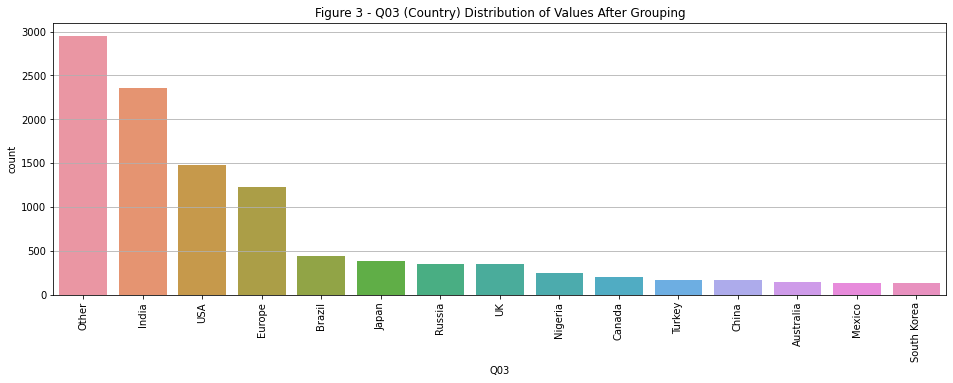

In [38]:
plt.figure(figsize=(16,5))
sns.countplot(x='Q03', data=df, order = df['Q03'].value_counts().index[:15])
plt.title('Figure 3 - Q03 (Country) Distribution of Values After Grouping')
plt.xticks(rotation=90)
fig.subplots_adjust(bottom=0.3)
plt.grid(axis='y')
#plt.tight_layout
plt.savefig('figure3.png', dpi=550)
plt.show()

A personal computer or laptop                                          7597
A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)    1662
A deep learning workstation (NVIDIA GTX, LambdaLabs, etc)               627
Other                                                                   152
None                                                                    130
Name: Q11, dtype: int64


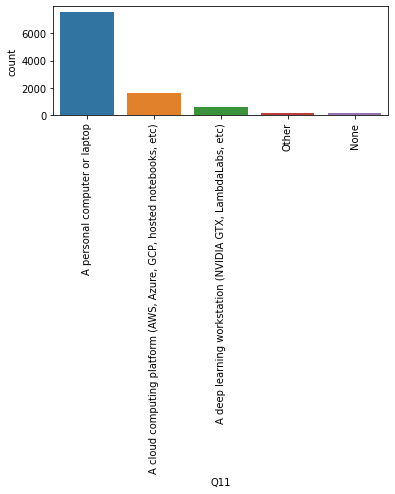

In [39]:
print(df['Q11'].value_counts())
fig = plt.figure(figsize=(6,2))
sns.countplot(x=df['Q11'], data=df)
plt.xticks(rotation=90)
plt.show()

In [40]:
#we replace all NaN Values with 'A laptop' since it is the most common answer
df.at[df['Q11'].isnull(), 'Q11'] = 'A personal computer or laptop'

#we verify that all NaN values are gone
df[df['Q11'].isnull()]

,Q01,Q02,Q03,Q04,Q05,...,Q39_Part_6,Q39_Part_7,Q39_Part_8,Q39_Part_9,Target_Encoded


Local development environments (RStudio, JupyterLab, etc.)              4289
Basic statistical software (Microsoft Excel, Google Sheets, etc.)       2815
Business intelligence software (Salesforce, Tableau, Spotfire, etc.)     676
Advanced statistical software (SPSS, SAS, etc.)                          621
Cloud-based data software & APIs (AWS, GCP, Azure, etc.)                 580
Other                                                                    495
Name: Q38, dtype: int64


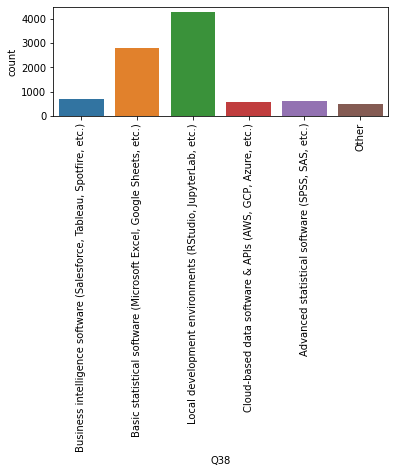

In [41]:
print(df['Q38'].value_counts())
fig = plt.figure(figsize=(6,2))
sns.countplot(x=df['Q38'], data=df)
plt.xticks(rotation=90)
plt.show()

In [42]:
#we replace all NaN Values with 'mode'
df.at[df['Q38'].isnull(), 'Q38'] = 'Local development environments (RStudio, JupyterLab, etc.)'

#we verify that all NaN values are gone
df[df['Q38'].isnull()]

,Q01,Q02,Q03,Q04,Q05,...,Q39_Part_6,Q39_Part_7,Q39_Part_8,Q39_Part_9,Target_Encoded


In [43]:
df[one_hot_encode_cols].info()

# for single-column questions, we one hot encoding them and store in df2
for col in one_hot_encode_cols:
    dummies = pd.get_dummies(df[col], prefix=col)
    df2 = pd.concat([df2, dummies], axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10729 entries, 1 to 10729
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q02     10729 non-null  object
 1   Q03     10729 non-null  object
 2   Q05     10729 non-null  object
 3   Q11     10729 non-null  object
 4   Q38     10729 non-null  object
dtypes: object(5)
memory usage: 822.9+ KB


### **1.C. Multi-Column Questions:**

All the multi-column questions are purely categorical data (non-ordinal) and are half encoded already.  We can convert these to one-hot encoding by converting string values to 1 and NaN values to 0.

In [44]:
# multi-col questions will have null values replaced with 0 and non-null
# replaced with 1
for col in multi_cols:
    df.at[df[col].notnull(), col] = 1
    df.at[df[col].isnull(), col] = 0
    df2[col] = df[col]
    
df2 = df2.reindex(sorted(df2.columns), axis=1)
df2 = df2.astype(int)
df2.head()

,Q01,Q02_Female,Q02_Male,Q02_Other,Q03_Australia,...,Q39_Part_6,Q39_Part_7,Q39_Part_8,Q39_Part_9,Target_Encoded
1,3,0,1,0,0,...,1,0,1,0,10
2,4,0,1,0,0,...,1,0,0,0,1
3,3,0,1,0,0,...,0,0,0,0,11
4,4,0,1,0,0,...,0,0,0,1,7
5,4,0,1,0,0,...,0,0,1,1,3


In [89]:
#verify that there are no nulls
#df2.info(max_cols=400)

### **Question 2 - Exploratory Data Analysis & Feature Selection [3pts]**

* For the exploratory data analysis step, visualize the order of feature importance. Some possible methods include correlation plot, or a similar method. Given the data, which of the original attributes in the data are most related to a survey respondent’s yearly compensation?

* Explain how feature engineering is a useful tool in machine learning in the context of the tasks in
this assignment. Apply feature engineering and then select the features to be used for analysis
either manually or through some feature selection algorithm (e.g. regularized regression).

* Not all features need to be used; features can be removed or added as desired. If the resulting
number of features is very high, dimensionality reduction can also be used (e.g. PCA). Use at
least one feature selection technique – describe the technique and **provide justification** on why
you selected that set of features.

In [46]:
df2.head()

,Q01,Q02_Female,Q02_Male,Q02_Other,Q03_Australia,...,Q39_Part_6,Q39_Part_7,Q39_Part_8,Q39_Part_9,Target_Encoded
1,3,0,1,0,0,...,1,0,1,0,10
2,4,0,1,0,0,...,1,0,0,0,1
3,3,0,1,0,0,...,0,0,0,0,11
4,4,0,1,0,0,...,0,0,0,1,7
5,4,0,1,0,0,...,0,0,1,1,3


In [49]:
corr_df = df2.corr()
tgt_corr = corr_df[abs(corr_df['Target_Encoded'])>=0.15]
print(len(tgt_corr))
#tgt_corr.index
tgt_corr.Target_Encoded.sort_values()

22


Q03_India                           -0.271049
Q03_Other                           -0.211786
Q29_B_Part_1                        -0.154335
Q11_A personal computer or laptop   -0.150335
Q23_Part_5                           0.156142
Q36_Part_9                           0.169297
Q07_Part_10                          0.169667
Q28_A_Part_10                        0.176446
Q09_Part_9                           0.177874
Q04                                  0.179216
Q27_A_Part_1                         0.198860
Q26_A_Part_1                         0.204226
Q20                                  0.208824
Q23_Part_3                           0.229095
Q21                                  0.249997
Q22                                  0.273736
Q15                                  0.354709
Q01                                  0.367102
Q06                                  0.375758
Q25                                  0.381985
Q03_USA                              0.519362
Target_Encoded                    

In [50]:
tgt_corr = tgt_corr[tgt_corr.index]
tgt_corr.rename(columns={'Q11_A personal computer or laptop':'Q11_laptop'}, 
                index={'Q11_A personal computer or laptop':'Q11_laptop'},
                inplace=True)

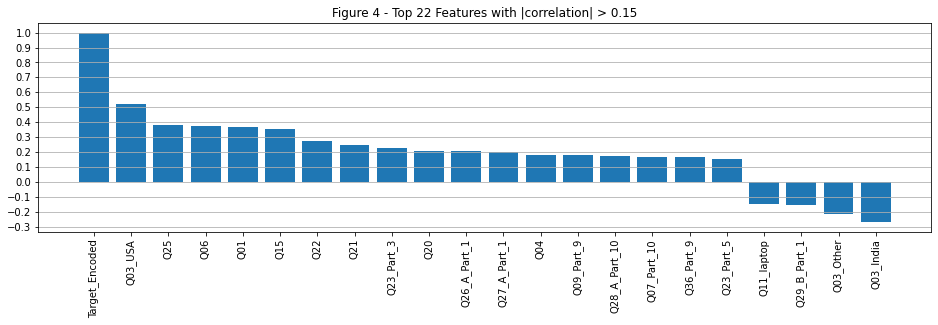

In [51]:
# plot correlation of top 22 features
fig, ax = plt.subplots(figsize=(16,5))

plt.bar(tgt_corr.Target_Encoded.sort_values(ascending=False).index,
        tgt_corr.Target_Encoded.sort_values(ascending=False))
plt.xticks(rotation=90)
plt.yticks(np.arange(-0.3,1.1,0.1))
plt.grid(axis='y')
plt.title('Figure 4 - Top 22 Features with |correlation| > 0.15')
fig.subplots_adjust(bottom=0.3)
plt.savefig('figure4.png', dpi=550)
plt.show()

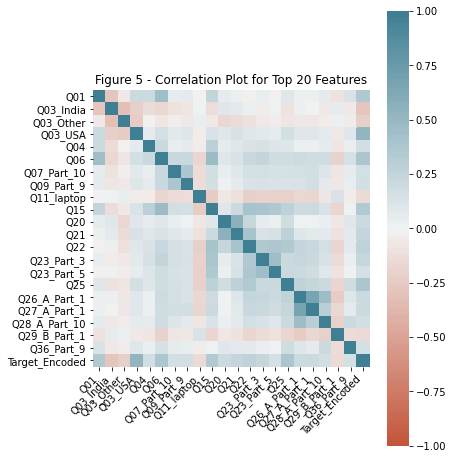

In [52]:
# correlation matrix plot
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(tgt_corr, vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
plt.title('Figure 5 - Correlation Plot for Top 20 Features')
plt.tight_layout
fig.subplots_adjust(left=0.3)
plt.savefig('figure5.png', dpi=550)
plt.show()

In [53]:
# keep only features with correlation > 0.13
cols_to_keep = corr_df[abs(corr_df['Target_Encoded'])>=0.13].Target_Encoded.index
df2 = df2[cols_to_keep]
df2.shape

(10729, 31)

### **Question 3 - Model Implementation [4pts]**

Implement ordinal logistic regression algorithm on the training data using **10-fold crossvalidation**. 

* How does your model accuracy compare across the folds? 

* What is average and variance of accuracy for folds? 

* Treating each value of hyperparameter(s) as a new model, which model performed best? Give the reason based on bias-variance trade-off. 

* An output of your algorithm should be a probability of belonging to each of the salary buckets. Apply scaling/normalization of features, if necessary, and justify the reason why scaling/normalization is (not) needed.

In [54]:
#First we split feature data (X) and target data (y)
X = df2.drop(['Target_Encoded'], axis=1)
y = df2.Target_Encoded

print("X shape: ", X.shape)
print("y shape: ", y.shape)

#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X shape:  (10729, 30)
y shape:  (10729,)
X_train shape:  (7510, 30)
X_test shape:  (3219, 30)
y_train shape:  (7510,)
y_test shape:  (3219,)


In [55]:
def ordinal_log_regression(X_train, y_train, X_test, C, penalty, 
                           solver='liblinear', standardize=True):
    '''
    Conducts an ordinal (multiclass) process using: 
    sklearn.linear_model.LogisticsRegression() on a given set of X_train, y_train 
    data in order to return predictions for a new X_test data.

    ARGS:
    X_train (NxF array/df)  - Training data features to train model
    y_train (Nx1 array)     - Training data targets to train model
    X_test (MxF array/df)   - Test data features to make predictions on
    C (float)               - Inverse of regularization strength (lambda)
    solver (string)         - Algorithm to use to optimize problem:
                                    - 'newton-cg','lbfgs','liblinear'
    penalty (string)        - Regularization method: 'l1', 'l2' or 'none'

    RTN:
    predictions (Mx1 array) - Predictions to compare with y_test

    NOTES: 
    'l1' only supported by 'liblinear', 
    'none' is supported by 'newton-cg', 'lbfgs'
    '''

    #since l1 regularization can only work with liblinear
    if penalty == 'l1':
        solver = 'liblinear'
    
    #Note. 'lbfgs' and 'newton-cg' require more iterations:
    if solver == 'lbfgs' or solver == 'newton-cg':
        max_iter = 1000
    else:
        max_iter = 100

    scaler = StandardScaler()
    model = LogisticRegression(C=C, penalty=penalty, solver=solver,
                               max_iter=max_iter)

    # store previous binary probabiility class 0 column so we can use to 
    # subtract on next iteration to calculate next class 0.
    # store final probability in prob_matrix
    prev_prob = np.zeros(len(X_test))
    prob_matrix = np.zeros((len(X_test),15))

    if standardize == True:
        # fit on training data and tranform both training and validation
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # need to run regression 14 times since we have 15 target classes to
    # convert to binary
    for i in range(14):
        # convert target (y) to binary problem # i
        bin_func = np.vectorize(lambda x: 0 if x <=i else 1)
        y_train_bin = bin_func(y_train)
                
        # train model on binary problem # i        
        model.fit(X_train, y_train_bin)
        # using validation data predict probabilities for binary problem # i
        # rtns a 2D array with prob. for class 0 and 1 in repective cols.
        bin_probabilities = model.predict_proba(X_test)[:, 0]

        # subtract previous class i-1 probability and store in matrix
        # since we don't want negative probabilities, implement np.vectorize
        # to convert those into 0
        kill_negative = np.vectorize(lambda x: 0 if x < 0 else x)
        class_i_probability = kill_negative(bin_probabilities - prev_prob)
        prob_matrix[:, i] = class_i_probability
        if i == 13:
            prob_matrix[:, i+1] = 1 - bin_probabilities
        # reset previous probabilities to probability of class 0
        prev_prob = bin_probabilities
        
        #return max value from each 
        predictions = np.argmax(prob_matrix, axis=1)

    return predictions

In [56]:
def cross_validate_OLR(X_train, y_train, C, penalty, solver='liblinear', 
                      n_splits=10, standardize=True):
    '''
    Conducts k-fold cross-validation using ordinal (multi-class) logistics 
    regression function previously defined.  Results in k x 1 array of accuracy
    accross each split 

    ARGS:
    X_train (NxF array) - Full training data
    C, solver, penalty  - Inputs to ordinal_log_regression() function
    n_splits (int)      - Number of splits and folds
    standardize (bool)  - if True, apply standardization to data set

    RTN:
    accuracy (kx1 array)- List of accuracies per cross-validation split
    '''

    kfold = KFold(n_splits=n_splits)  # create 10 folds 
    kfold.get_n_splits(X_train) # split X_train into 10 splits with 10 folds
    scaler = StandardScaler()

    accuracy = np.zeros(10)     # store each cross-validation split accuracy
    np_idx = 0                  # split count

    # loop through each split of the 'folds' number of kfolds 
    for train_idx, val_idx in kfold.split(X_train):
        # for each split, split training data into train_CV and validation_CV
        X_train_CV, X_val_CV = X_train.values[train_idx], X_train.values[val_idx]
        y_train_CV, y_val_CV = y_train.values[train_idx], y_train.values[val_idx]

        predictions = ordinal_log_regression(X_train_CV, y_train_CV, X_val_CV, 
                                            C=C, penalty=penalty, solver=solver,
                                             standardize=standardize)

        #calculate accuracy using sklearn.metrics.accuracy_score
        ACC = accuracy_score(y_val_CV, predictions)

        accuracy[np_idx] = ACC*100
        np_idx += 1

    return accuracy

In [57]:
# run function to (1) see what happens when you change L1 to L2 regularization 
# and (2) see effect of standardization
accuracy1 = cross_validate_OLR(X_train, y_train, C=1, penalty='l2')
accuracy2 = cross_validate_OLR(X_train, y_train, C=1, penalty='l1')
accuracy3 = cross_validate_OLR(X_train, y_train, C=1, penalty='l2', standardize=False)

array([44.20772304, 45.67243675, 43.80825566, 41.94407457, 45.80559254,
       43.80825566, 44.07456724, 41.81091877, 41.14513981, 43.67509987])

In [87]:
print("C=1, L2 regularization, standardized:", np.mean(accuracy1))
print("C=1, L1 regularization, standardized:", np.mean(accuracy2))
print("C=1, L2 regularization, not-standardized:", np.mean(accuracy3))

print("C=1, L2 regularization, standardized:", np.std(accuracy1))
print("C=1, L1 regularization, standardized:", np.std(accuracy2))
print("C=1, L2 regularization, not-standardized:", np.std(accuracy3))

C=1, L2 regularization, standardized: 43.59520639147803
C=1, L1 regularization, standardized: 43.635153129161125
C=1, L2 regularization, not-standardized: 43.64846870838882
C=1, L2 regularization, standardized: 1.4770092808375017
C=1, L1 regularization, standardized: 1.5206018357396223
C=1, L2 regularization, not-standardized: 1.5179760319573894


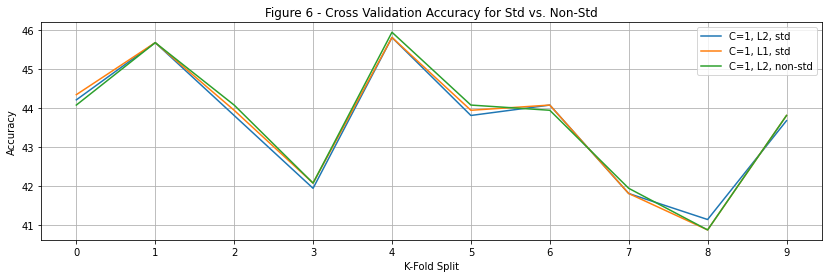

In [61]:
# plot accuracy across 10 k-folds for each of the 3 models above
plt.figure(figsize=(14,4))
plt.plot(np.arange(0,10), accuracy1, label='C=1, L2, std')
plt.plot(np.arange(0,10), accuracy2, label='C=1, L1, std')
plt.plot(np.arange(0,10), accuracy3, label='C=1, L2, non-std')
plt.grid()
plt.title("Figure 6 - Cross Validation Accuracy for Std vs. Non-Std")
plt.xlabel('K-Fold Split')
plt.xticks(np.arange(0,10))
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('figure6.png', dpi=550)
plt.show()

### **Question 4 - Model Tuning [3pts]**

* Identify all hyperparameters in your model. Select two hyperparameters for model tuning and justify your selection. 

* Improve the performance of the models from the previous step with hyperparameter tuning and select a final optimal model using grid search based on a metric (or metrics) that you choose. 

* Choosing an optimal model for a given task (comparing multiple classifiers on a specific domain) requires selecting performance measures, for example accuracy, precision, recall and/or F1-score to compare the model performance. Justify the metric you selected. There is no minimum model accuracy, as long as your methodology is reasonable and well explained. 

In [80]:
#hyperparameters
C_list = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1]
penalties = ['l1','l2']
l1_accuracies = []              # initialize empty list to store L1 accuracies
l2_accuracies = []              # initialize empty list to store L2 accuracies

best_params = {}                # initialize best hyperparameters
best_accuracy = 0               # store best accuracy
best_std = 0

# loop through all hyperparameters as a grid search
for C in C_list:
    for penalty in penalties:
        
        accuracy = cross_validate_OLR(X_train, y_train, C=C, penalty=penalty)
        print("C = {}, penalty = {} -Avg accuracy: {}% ({}%)".format(
            C, penalty, round(np.mean(accuracy),2), round(np.std(accuracy),2)))
        
        # store accuracy values in lists for plotting
        if penalty == 'l1':
            l1_accuracies.append(round(np.mean(accuracy),2))
        else:
            l2_accuracies.append(round(np.mean(accuracy),2))
        
        if np.mean(accuracy) > best_accuracy:
            best_params = {'C':C, 'penalty':penalty}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)
        
print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} penalty, and has a cross\n \
validation score of {}% with a standard \
deviation of {}%".format(best_params['C'], best_params['penalty'],
                         round(best_accuracy,3),round(best_std,3)))

C = 0.001, penalty = l1 -Avg accuracy: 41.64% (1.43%)
C = 0.001, penalty = l2 -Avg accuracy: 41.49% (1.61%)
C = 0.005, penalty = l1 -Avg accuracy: 43.04% (1.42%)
C = 0.005, penalty = l2 -Avg accuracy: 43.17% (1.2%)
C = 0.01, penalty = l1 -Avg accuracy: 43.72% (1.43%)
C = 0.01, penalty = l2 -Avg accuracy: 43.45% (1.65%)
C = 0.02, penalty = l1 -Avg accuracy: 43.61% (1.52%)
C = 0.02, penalty = l2 -Avg accuracy: 43.54% (1.72%)
C = 0.05, penalty = l1 -Avg accuracy: 43.73% (1.5%)
C = 0.05, penalty = l2 -Avg accuracy: 43.5% (1.61%)
C = 0.1, penalty = l1 -Avg accuracy: 43.72% (1.56%)
C = 0.1, penalty = l2 -Avg accuracy: 43.64% (1.6%)
C = 0.5, penalty = l1 -Avg accuracy: 43.65% (1.5%)
C = 0.5, penalty = l2 -Avg accuracy: 43.64% (1.52%)
C = 1, penalty = l1 -Avg accuracy: 43.64% (1.52%)
C = 1, penalty = l2 -Avg accuracy: 43.6% (1.48%)
{'C': 0.05, 'penalty': 'l1'}
Best Score: 43.728%(1.501%)

The optimal log model uses C=0.05, and a l1 penalty, and has a cross
 validation score of 43.728% with a s

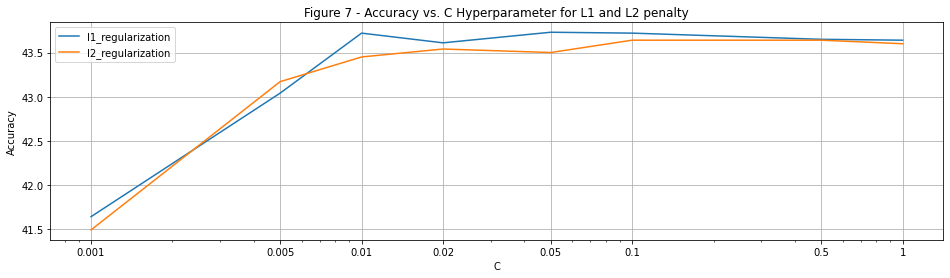

In [84]:
# plot accuracy vs. hyperparameter models for L1 vs. L2 penalty
plt.figure(figsize=(16,4))
plt.plot(C_list, l1_accuracies, label='l1_regularization')
plt.plot(C_list, l2_accuracies, label='l2_regularization')
plt.grid()
plt.title("Figure 7 - Accuracy vs. C Hyperparameter for L1 and L2 penalty")
plt.xscale('log')
plt.xticks(C_list, labels=C_list)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('figure7.png', dpi=550)
plt.show()

### **Question 5 - Testing & Discussion [4pts]**

* Use your optimal model to make classifications on the test set. How does your model perform on
the test set vs. the training set? 

* The overall fit of the model, how to increase the accuracy (test,training)? Is it overfitting or underfitting? Why? 

* Plot the distribution of true target variable values and their predictions on both the training set and test set. What insight have you gained from the
dataset and your trained classification model?

Insufficient discussion will lead to the deduction of marks. 

In [88]:
y_train_pred = ordinal_log_regression(X_train,y_train, X_train, C=0.01, penalty='l1')
training_set_accuracy = accuracy_score(y_train, y_train_pred)*100
print("Model peformance on full training dataset: {}%".format(
    round(training_set_accuracy,2)), "\n")

y_test_pred = ordinal_log_regression(X_train,y_train, X_test, C=0.01, penalty='l1')
test_set_accuracy = accuracy_score(y_test, y_test_pred)*100
print("Model peformance on full training dataset: {}%".format(
    round(test_set_accuracy,2)))

Model peformance on full training dataset: 43.69% 

Model peformance on full training dataset: 42.81%


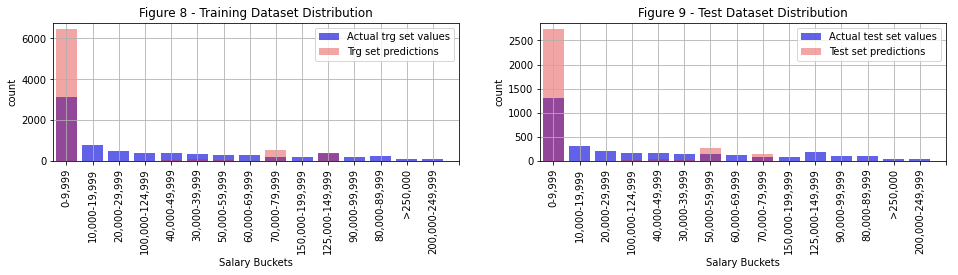

In [85]:
# obtain axis labels from original Q24_buckets column
axis_labels = list(df.Q24.value_counts().index)
axis_labels.append(" ")

# plot distributions for training and test using subplots
fig, axes = plt.subplots(1,2, figsize=(16,4))

sns.countplot(x=y_train, color='blue', alpha=0.7, label='Actual trg set values', ax=axes[0])
sns.countplot(x=y_train_pred, color='red', alpha=0.4, label='Trg set predictions', ax=axes[0])
sns.countplot(x=y_test, color='blue', alpha=0.7, label='Actual test set values', ax=axes[1])
sns.countplot(x=y_test_pred, color='red', alpha=0.4, label='Test set predictions', ax=axes[1])
plt.title('Figure X - Test Dataset Distribution of Actual vs. Predicted Values')
axes[0].set_title('Figure 8 - Training Dataset Distribution', loc='center')
axes[1].set_title('Figure 9 - Test Dataset Distribution', loc='center')
# to duplicate certain aspects across both axes
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(np.arange(0,16),labels=axis_labels, rotation=90)
    plt.xlabel('Salary Buckets')
    plt.legend()
    plt.grid(axis='both')
fig.subplots_adjust(bottom=0.4)
#
plt.savefig('figure8-9.png',dpi=550)
plt.show()